#### Background
The study will adopt a Classification approach using Weigth of Evidence to determine/predict a default/deliquent event.

In [1]:
# Import the required libraries
import os
import random
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from scipy.stats import chi2_contingency
import logging
import joblib

from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# Set seed
SEED = 42


def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    #tf.random.set_seed(seed)
    np.random.seed(seed)


def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'


set_global_determinism(seed=SEED)


In [3]:
# Reading the dataset
main = pd.read_csv('./credit_risk_dataset_training.csv')

In [4]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22850 entries, 0 to 22849
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  22850 non-null  int64  
 1   person_income               22850 non-null  int64  
 2   person_home_ownership       22850 non-null  object 
 3   person_emp_length           22237 non-null  float64
 4   loan_intent                 22850 non-null  object 
 5   loan_grade                  22850 non-null  object 
 6   loan_amnt                   22850 non-null  int64  
 7   loan_int_rate               20703 non-null  float64
 8   loan_status                 22850 non-null  int64  
 9   loan_percent_income         22850 non-null  float64
 10  cb_person_default_on_file   22850 non-null  object 
 11  cb_person_cred_hist_length  22850 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.1+ MB


Clearly, the categorical features are:
1. person_home_ownership
2. loan_intent
3. loan_grade
4. cb_person_default_on_file

And We have 11 independent variables and 1 target variable, i.e. *loan_status* in the training dataset.

In [5]:
main.shape

(22850, 12)

In [6]:
pd.options.display.max_columns = None
main.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
4,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3


In [7]:
main = main.drop_duplicates()

In [8]:
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22765 entries, 0 to 22849
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  22765 non-null  int64  
 1   person_income               22765 non-null  int64  
 2   person_home_ownership       22765 non-null  object 
 3   person_emp_length           22156 non-null  float64
 4   loan_intent                 22765 non-null  object 
 5   loan_grade                  22765 non-null  object 
 6   loan_amnt                   22765 non-null  int64  
 7   loan_int_rate               20629 non-null  float64
 8   loan_status                 22765 non-null  int64  
 9   loan_percent_income         22765 non-null  float64
 10  cb_person_default_on_file   22765 non-null  object 
 11  cb_person_cred_hist_length  22765 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.3+ MB


In [9]:
# explore the unique values in loan_status column and distribution
main['loan_status'].value_counts(normalize=True)

0    0.779222
1    0.220778
Name: loan_status, dtype: float64

In [10]:
main['person_home_ownership'].value_counts(normalize=True)

RENT        0.503888
MORTGAGE    0.412344
OWN         0.080430
OTHER       0.003338
Name: person_home_ownership, dtype: float64

In [11]:
X = main.drop('loan_status', axis=1)
y = main['loan_status']

In [12]:
X.describe()


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,22765.000000,2.276500e+04,22156.000000,22765.000000,20629.000000,22765.000000,22765.000000
mean,27.728311,6.607327e+04,4.802356,9599.481660,11.018502,0.170232,5.808302
std,6.333095,6.431803e+04,4.115383,6330.482222,3.245143,0.106545,4.054244
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,3.840000e+04,2.000000,5000.000000,7.900000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000
75%,30.000000,7.940000e+04,7.000000,12250.000000,13.470000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.780000,30.000000


In [13]:
# first divide training data into categorical and numerical subsets
X_cat = X.select_dtypes(include='object').copy()
X_num = X.select_dtypes(include='number').copy()

In [14]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_cat:
    chi, p, dof, ex = chi2_contingency(
        pd.crosstab(y, X_cat[column]))
    chi2_check.setdefault('Feature', []).append(column)
    chi2_check.setdefault('p-value', []).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data=chi2_check)
chi2_result.sort_values(by=['p-value'], ascending=True,
                        ignore_index=True, inplace=True)
chi2_result

,Feature,p-value
0,person_home_ownership,0.0
1,loan_intent,0.0
2,loan_grade,0.0
3,cb_person_default_on_file,0.0


We'll keep all the four categorical features

In [15]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
X_num.fillna(X_num.mean(), inplace=True)
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_num, y)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data={'Numerical_Feature': X_num.columns.values,
                             'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(
    by=['F-Score'], ascending=False, ignore_index=True, inplace=True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,loan_percent_income,3779.411586,0.000000
1,loan_int_rate,2552.282683,0.000000
2,person_income,453.872303,0.000000
3,loan_amnt,262.039340,0.000000
4,person_emp_length,142.289688,0.000000
5,person_age,9.162918,0.002472
6,cb_person_cred_hist_length,4.505864,0.033790


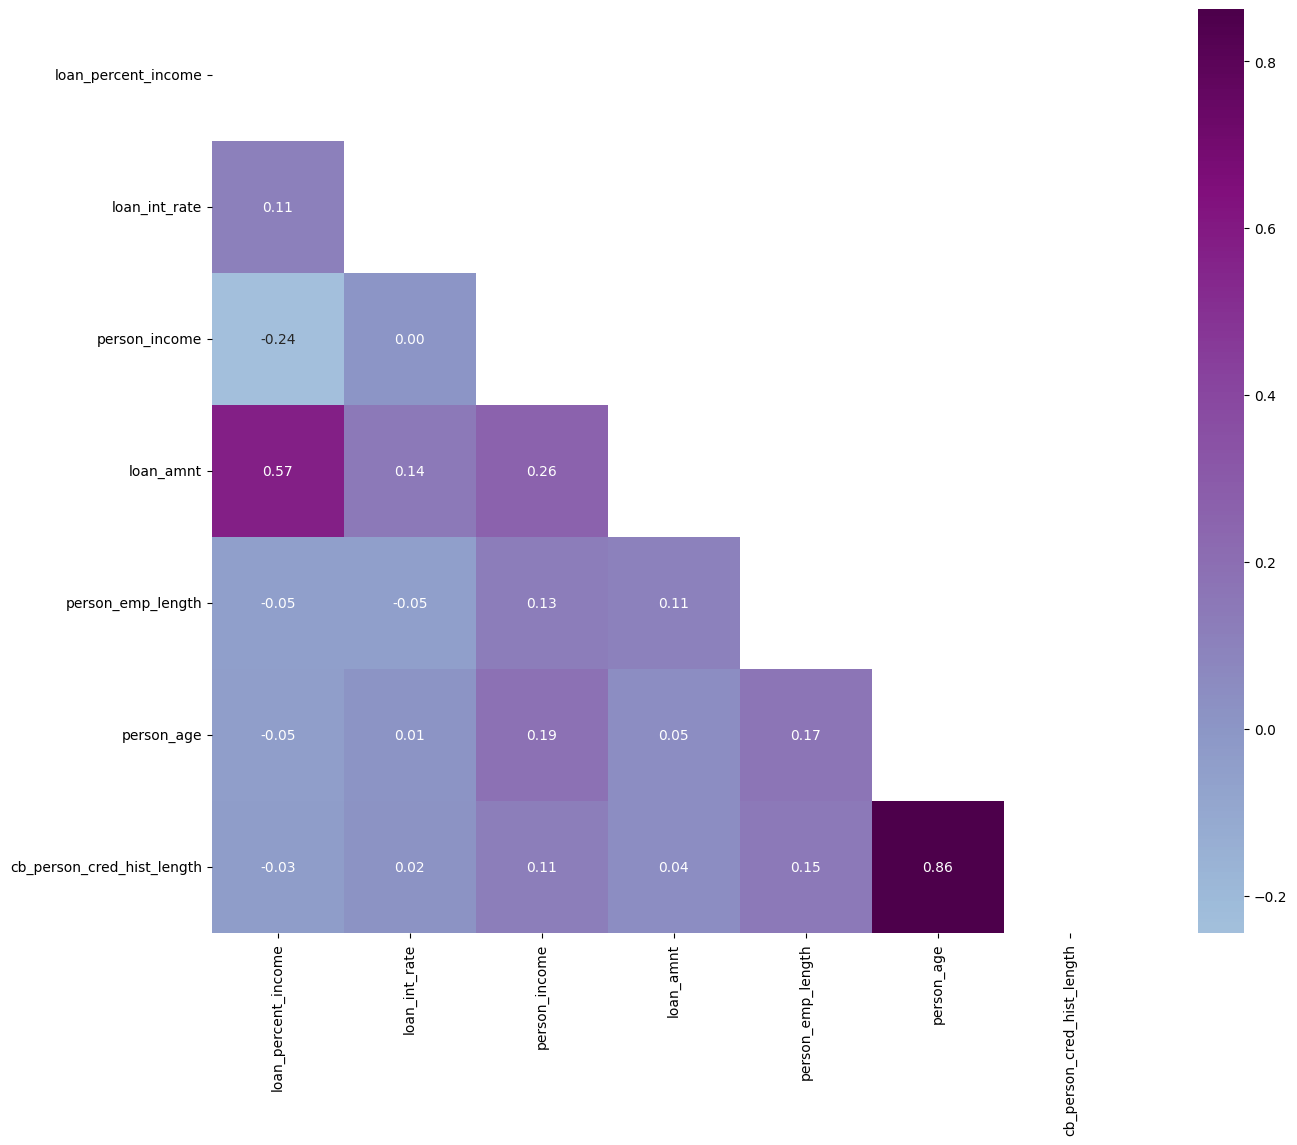

In [16]:
# save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:, 0].to_list()
# calculate pair-wise correlations between them
corrmat = X_num[top_num_features].corr()
plt.figure(figsize=(16, 12))
#cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
mask = np.triu(np.ones_like(corrmat, dtype=bool))
sns.heatmap(corrmat, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap="BuPu")

plt.savefig("./images/corrmat.png", dpi=1000, bbox_inches="tight")
plt.show()

we will keep all the features

In [17]:
X.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,22765.000000,2.276500e+04,22156.000000,22765.000000,20629.000000,22765.000000,22765.000000
mean,27.728311,6.607327e+04,4.802356,9599.481660,11.018502,0.170232,5.808302
std,6.333095,6.431803e+04,4.115383,6330.482222,3.245143,0.106545,4.054244
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,3.840000e+04,2.000000,5000.000000,7.900000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000
75%,30.000000,7.940000e+04,7.000000,12250.000000,13.470000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.780000,30.000000


In [18]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X.copy()
y_train_prepr = y.copy()

In [19]:
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis=1)
    df_woe_iv = pd.crosstab(df[cat_variabe_name], df['loan_status'], normalize='columns').assign(
        woe=lambda dfx: np.log(dfx[1]/dfx[0])).assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0])))
    return df_woe_iv

### EDA

#### Target Feature

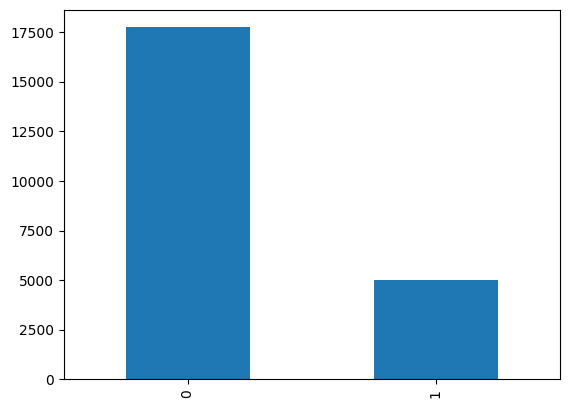

In [20]:
main['loan_status'].value_counts().plot.bar()
plt.savefig("./images/loan_status.png", dpi=1000, bbox_inches="tight")
plt.show()

#### Categorical Features

1. person_home_ownership
2. loan_intent
3. loan_grade
4. cb_person_default_on_file

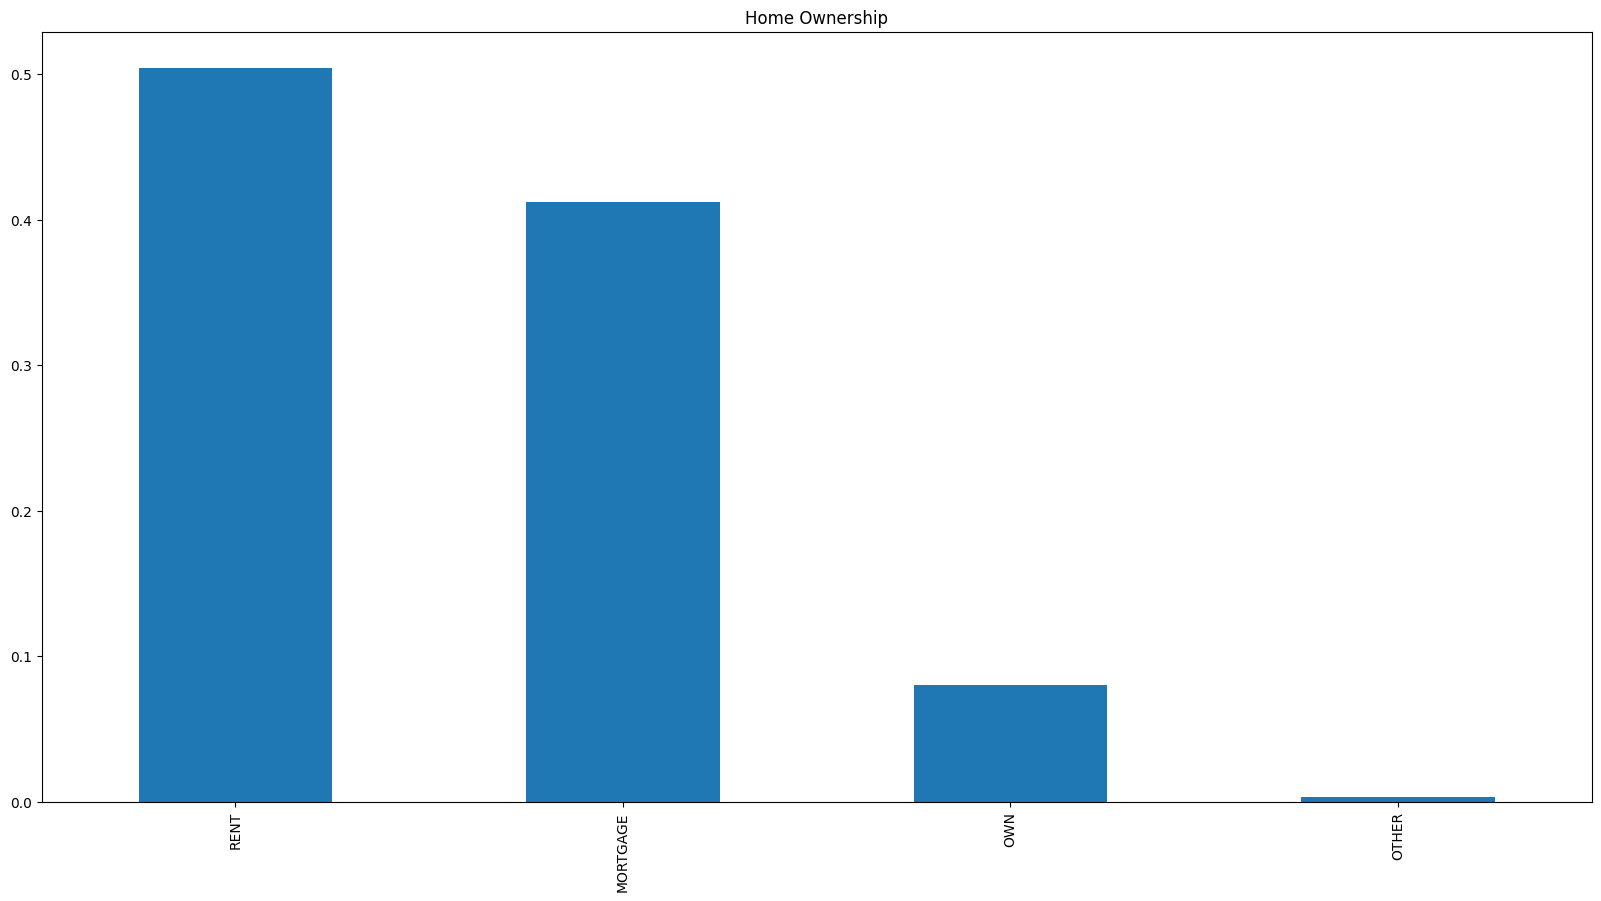

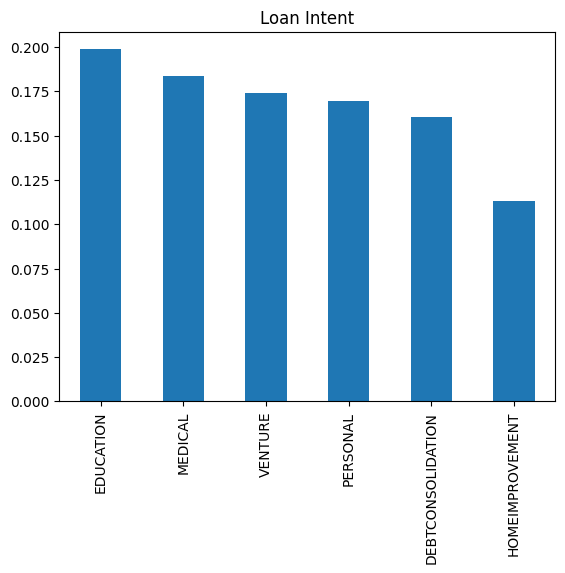

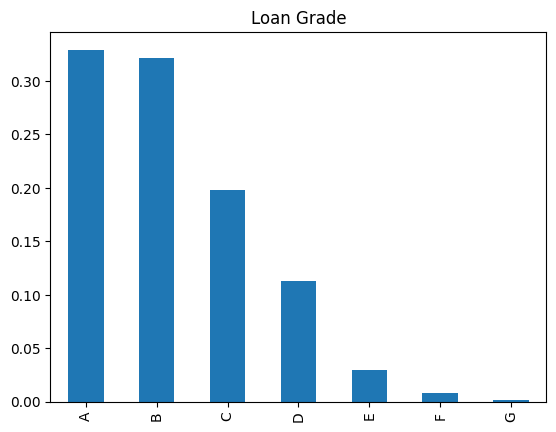

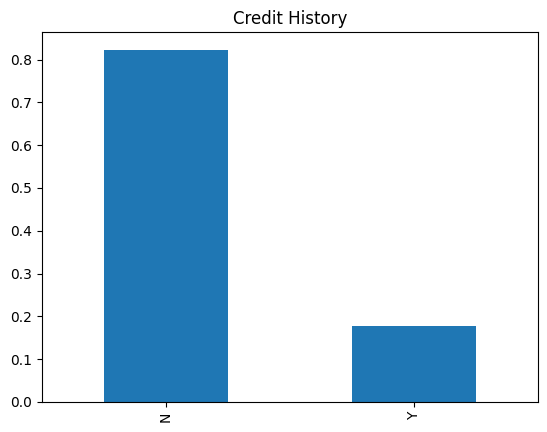

In [21]:
main['person_home_ownership'].value_counts(normalize=True).plot.bar(figsize=(20, 10), title='Home Ownership')
plt.savefig("./images/home.png", dpi=1000, bbox_inches="tight")
plt.show()
main['loan_intent'].value_counts(normalize=True).plot.bar(title='Loan Intent')
plt.savefig("./images/loan_intent.png", dpi=1000, bbox_inches="tight")
plt.show()
main['loan_grade'].value_counts(normalize=True).plot.bar(title='Loan Grade')
plt.savefig("./images/loan_grade.png", dpi=1000, bbox_inches="tight")
plt.show()
main['cb_person_default_on_file'].value_counts(normalize=True).plot.bar(title='Credit History')
plt.savefig("./images/credit_history.png", dpi=1000, bbox_inches="tight")
plt.show()

It can be inferred from the above bar plots that:
- Rent and Mortage are the major home ownerships with a cumulative percentage of about 90
- Loan intents are fairly distributed with home improvement having the lowest percentage of about 11%
- Loan Grade A & B are the major grade with about 32% each
- 80% applicants in the dataset dont hav a credit history

#### Numerical Features

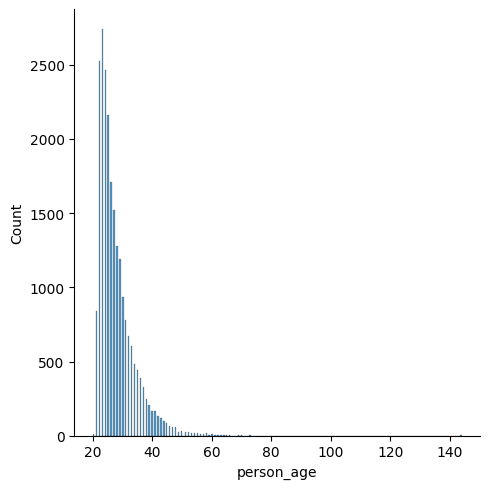

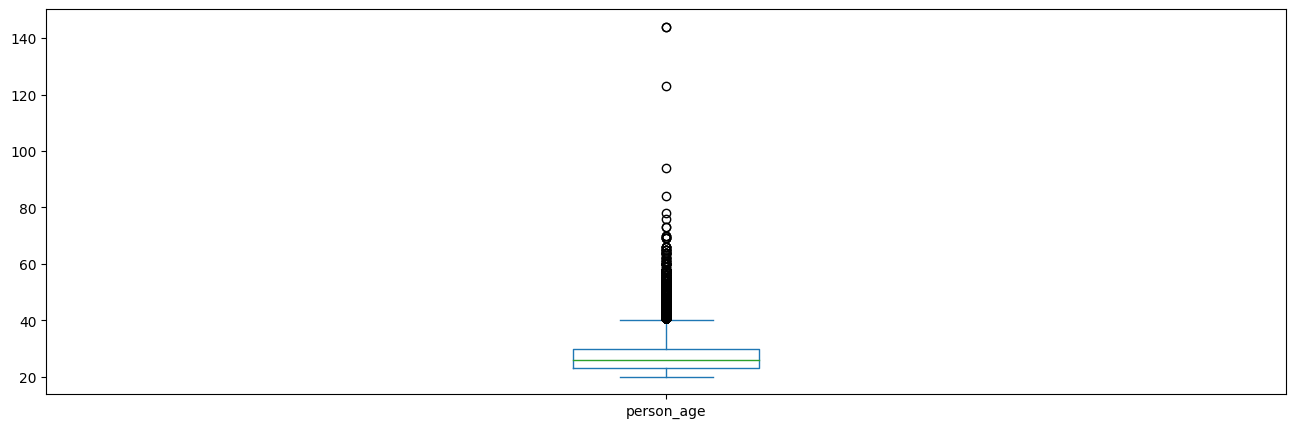

In [22]:
sns.displot(main['person_age'])
plt.savefig("./images/dist_corrmat.png", dpi=1000, bbox_inches="tight")
plt.show()
main['person_age'].plot.box(figsize=(16, 5))
plt.savefig("./images/box_age.png", dpi=1000, bbox_inches="tight")
plt.show()

It can be inferred that most of the data in the distribution of age is towards left which means it is not normally distributed. We will make it normal in later sections as algorithms works better if the data is normally distributed.

The boxplot confirms the presence of a lot of outliers/extreme values. This can be attributed to the age disparity in the society.

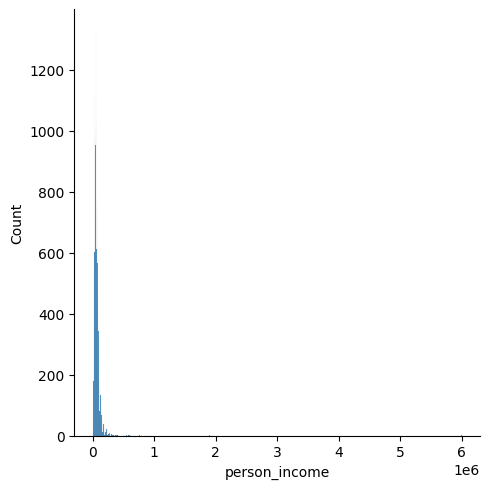

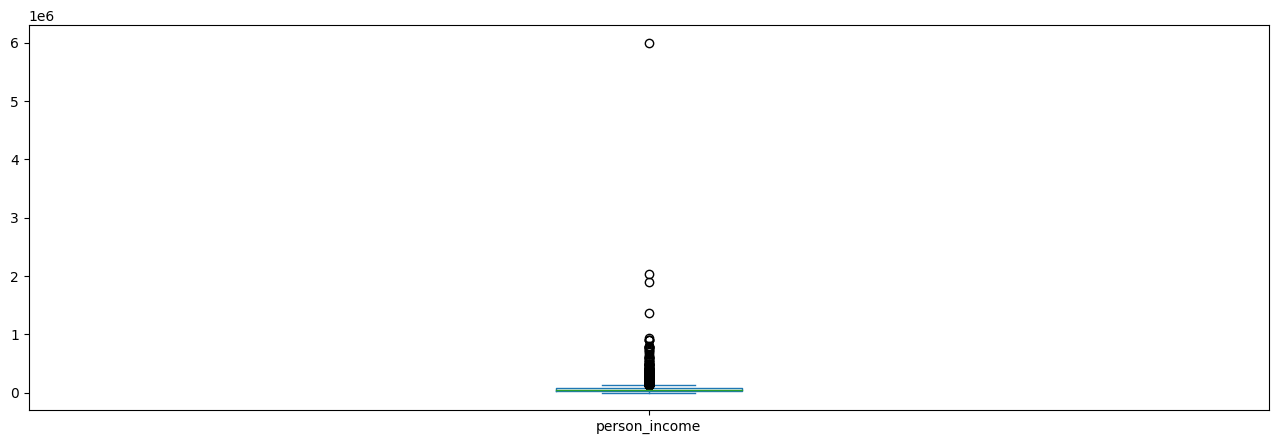

In [23]:
sns.displot(main['person_income'])
plt.savefig("./images/dist_income.png", dpi=1000, bbox_inches="tight")
plt.show()
main['person_income'].plot.box(figsize=(16, 5))
plt.savefig("./images/box_income.png", dpi=1000, bbox_inches="tight")
plt.show()

Most of the data in the distribution of income is towards the left which means it is not normally distributed. We will as well make it normal later.

The boxplot shows the presence of outliers/extreme values.

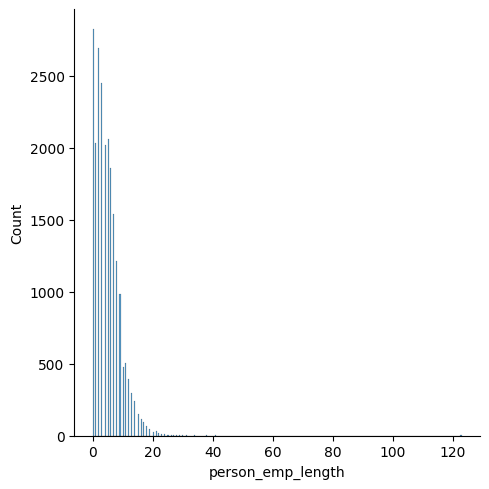

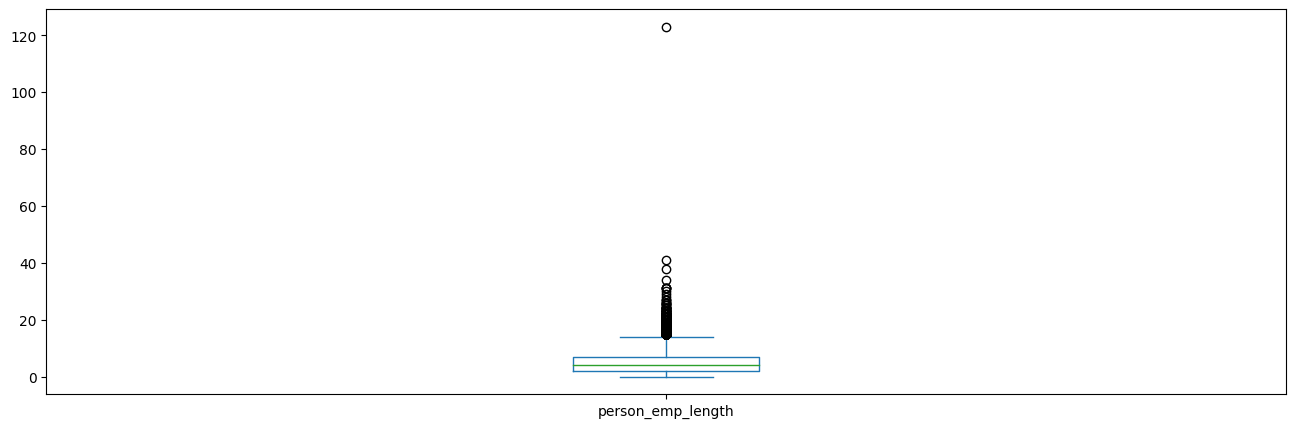

In [24]:
sns.displot(main['person_emp_length'])
plt.savefig("./images/dist_length.png", dpi=1000, bbox_inches="tight")
plt.show()
main['person_emp_length'].plot.box(figsize=(16, 5))
plt.savefig("./images/box_length.png", dpi=1000, bbox_inches="tight")
plt.show()

We see a a not-normal distribution where the majority of applicants having loan percent income ranging from 0.0 to 15.0. There are a lot of outliers as shown by the box plot.

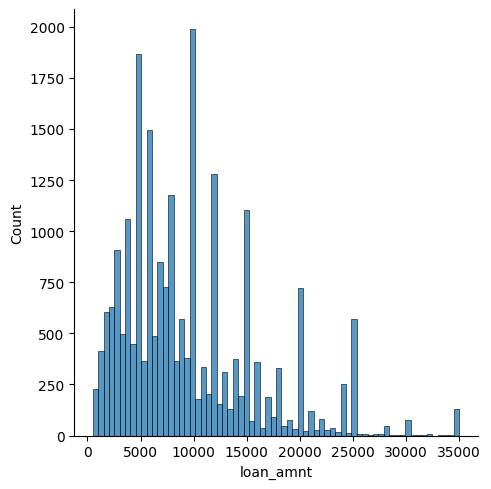

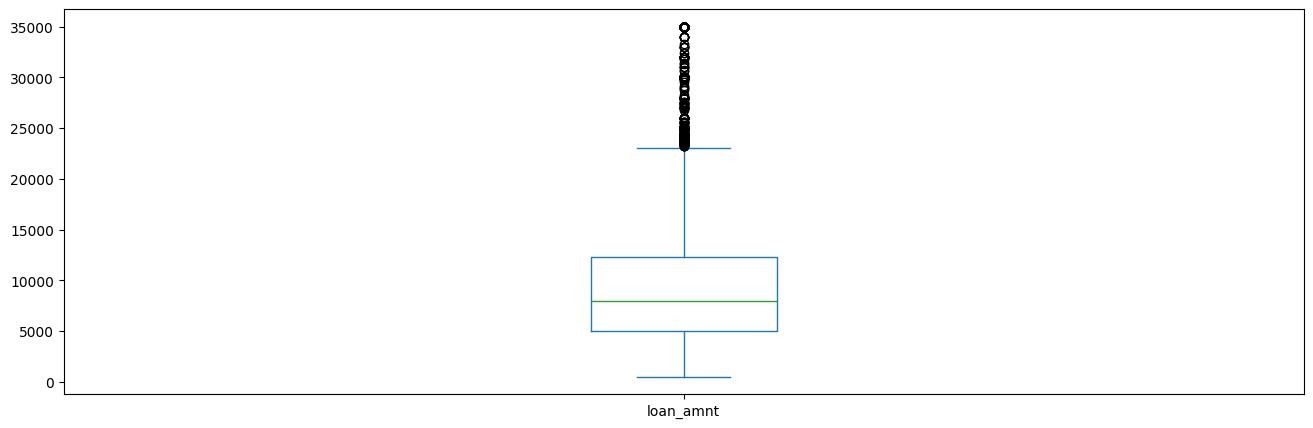

In [25]:
sns.displot(main['loan_amnt'])
plt.savefig("./images/dist_amnt.png", dpi=1000, bbox_inches="tight")
plt.show()
main['loan_amnt'].plot.box(figsize=(16, 5))
plt.savefig("./images/box_amnt.png", dpi=1000, bbox_inches="tight")
plt.show()

The loan amount has a distribution where the majority loan amounts range from about 500 to 23000. From the boxplot there are also a lot of outliers.

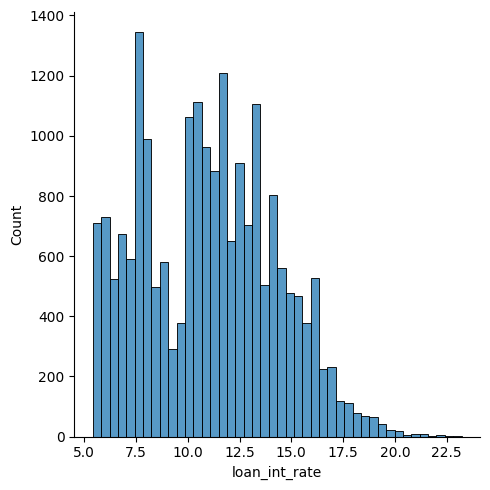

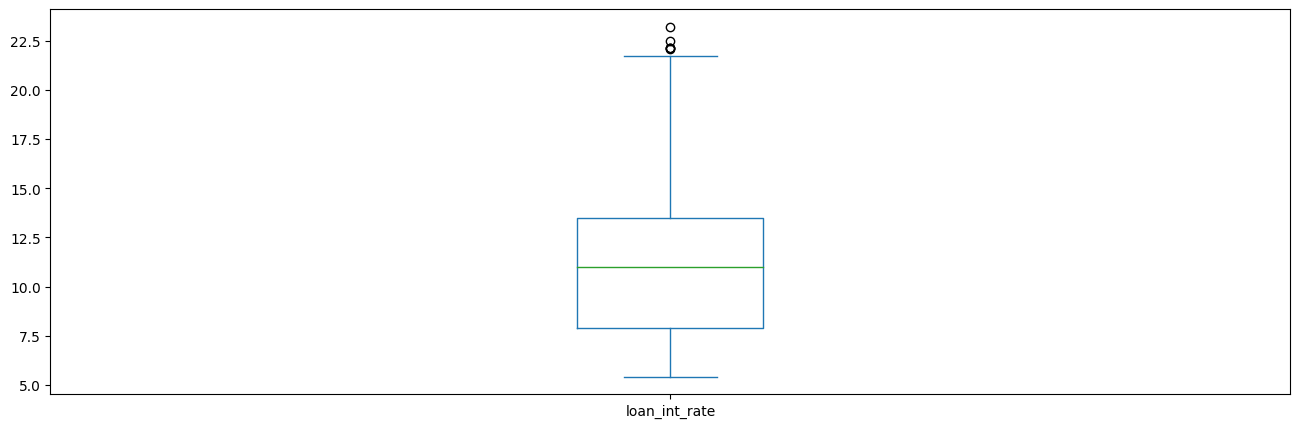

In [26]:
sns.displot(main['loan_int_rate'])
plt.savefig("./images/dist_rate.png", dpi=1000, bbox_inches="tight")
plt.show()
main['loan_int_rate'].plot.box(figsize=(16, 5))
plt.savefig("./images/box_rate.png", dpi=1000, bbox_inches="tight")
plt.show()

The distribution has a majority of applicants having loan interest rate ranging from 5.1 to 21.0. There are some outliers.

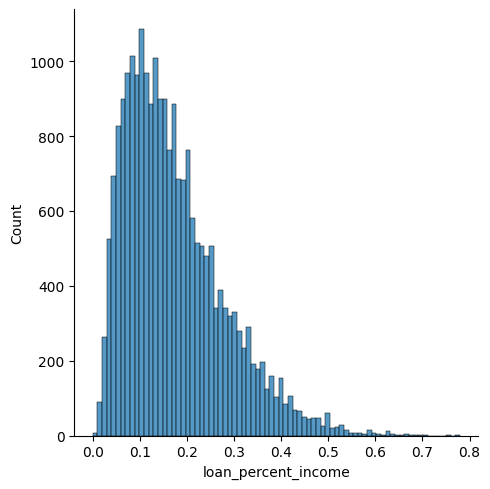

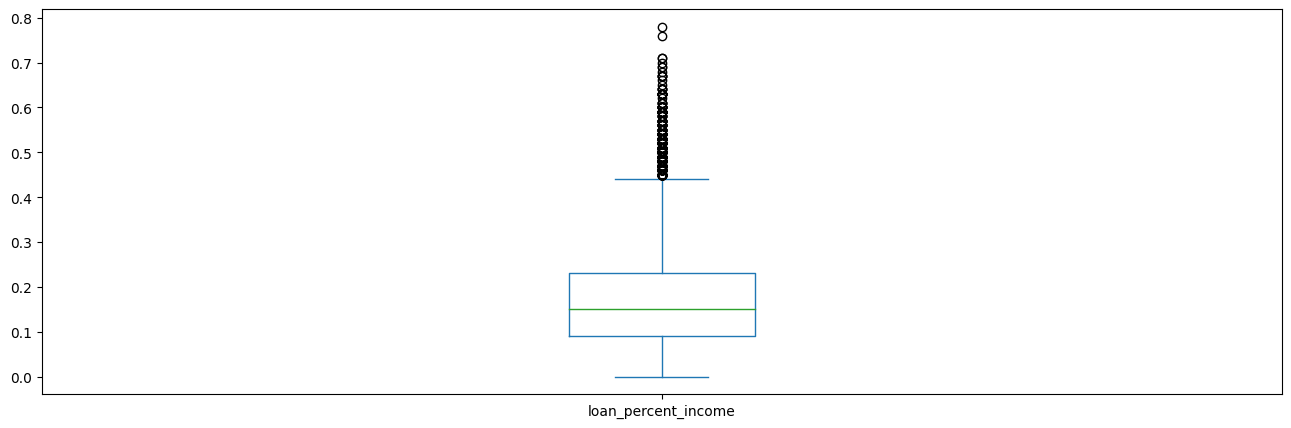

In [27]:
sns.displot(main['loan_percent_income'])
plt.savefig("./images/dist_income.png", dpi=1000, bbox_inches="tight")
plt.show()
main['loan_percent_income'].plot.box(figsize=(16, 5))
plt.savefig("./images/box_income.png", dpi=1000, bbox_inches="tight")
plt.show()

We see a distribution where the majority of applicants having loan percent income ranging from 0.0 to 0.45. There are a lot of outliers as shown from the boxplot.

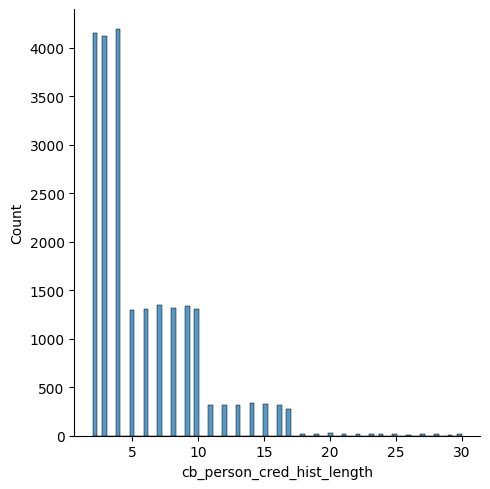

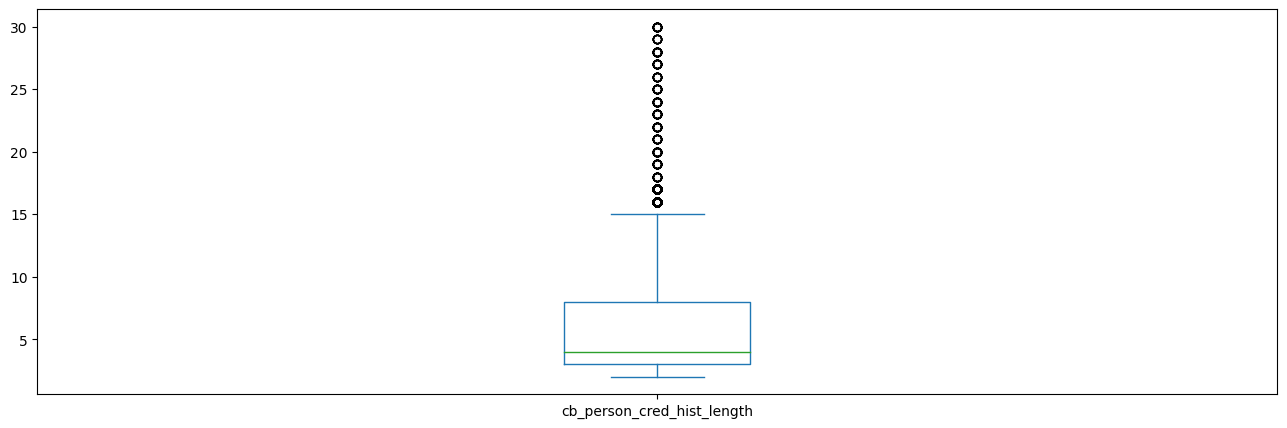

In [28]:
sns.displot(main['cb_person_cred_hist_length'])
plt.savefig("./images/dist_hlen.png", dpi=1000, bbox_inches="tight")
plt.show()
main['cb_person_cred_hist_length'].plot.box(figsize=(16, 5))
plt.savefig("./images/box_hlen.png", dpi=1000, bbox_inches="tight")
plt.show()

We see a distribution where the majority of applicants having credit history length ranging from 1 to 8. We also see a lot of outliers in the credit history length and it is also not normally distributed.

#### Bivariate Analysis
##### Categorical Independent Variable vs Target Variable

1. person_home_ownership
2. loan_intent
3. loan_grade
4. cb_person_default_on_file

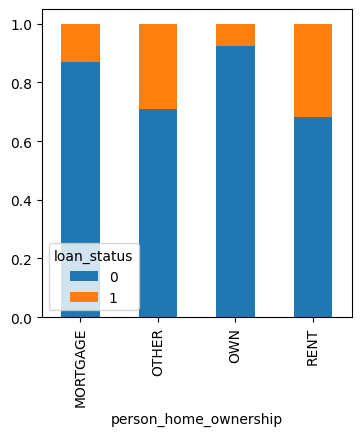

In [29]:
home = pd.crosstab(main['person_home_ownership'], main['loan_status'])
home.div(home.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4, 4))
plt.savefig("./images/bivar_home.png", dpi=1000, bbox_inches="tight")
plt.show()

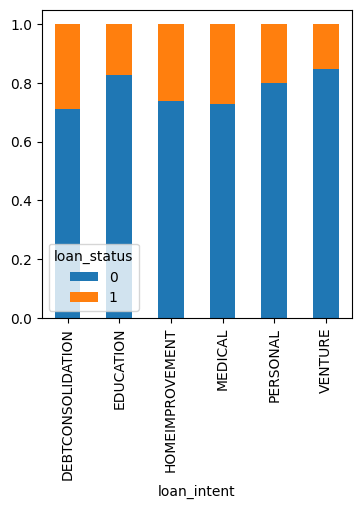

In [30]:
loan_intent = pd.crosstab(main['loan_intent'], main['loan_status'])
loan_intent.div(loan_intent.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4, 4))
plt.savefig("./images/bivar_loan_intent.png", dpi=1000, bbox_inches="tight")
plt.show()


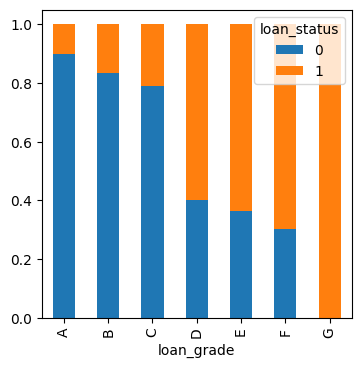

In [31]:
loan_grade = pd.crosstab(main['loan_grade'], main['loan_status'])
loan_grade.div(loan_grade.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4, 4))
plt.savefig("./images/bivar_loan_grade.png", dpi=1000, bbox_inches="tight")
plt.show()

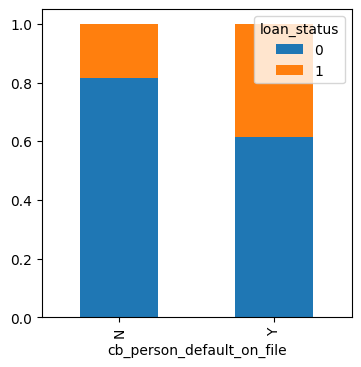

In [32]:
hist = pd.crosstab(main['cb_person_default_on_file'], main['loan_status'])
hist.div(hist.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4, 4))
plt.savefig("./images/bivar_default_file.png", dpi=1000, bbox_inches="tight")
plt.show()

##### Numerical Independent Variable vs Target Variable

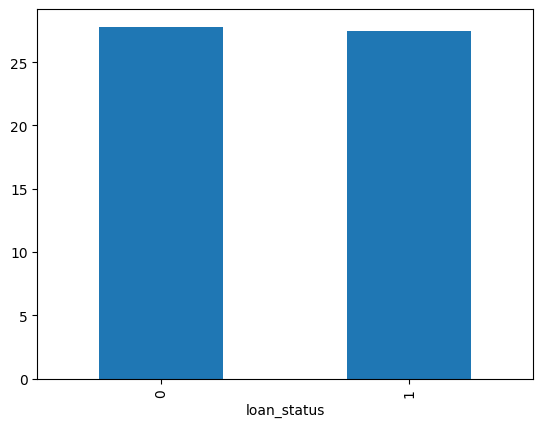

In [33]:
main.groupby('loan_status')['person_age'].mean().plot.bar()
plt.savefig("./images/loan_status_age.png", dpi=1000, bbox_inches="tight")
plt.show()

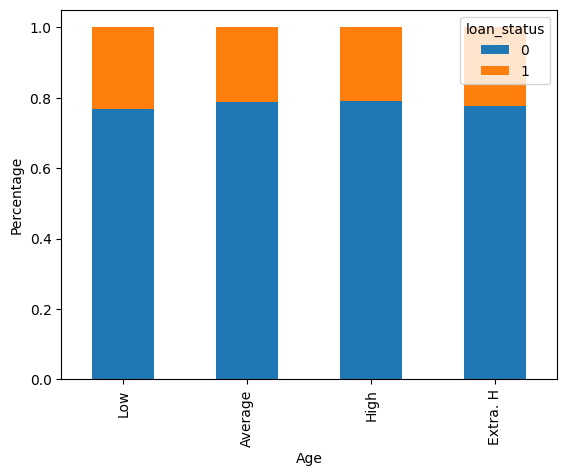

In [34]:
bins=[20,25,35,45,125]
group=['Low','Average','High', 'Extra. H']
main['person_age_bin'] = pd.cut(main['person_age'], bins, labels=group)
Age_bin=pd.crosstab(main['person_age_bin'],main['loan_status'])
Age_bin.div(Age_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel('Age')
plt.savefig("./images/bivar_age.png", dpi=1000, bbox_inches="tight")
P=plt.ylabel('Percentage')

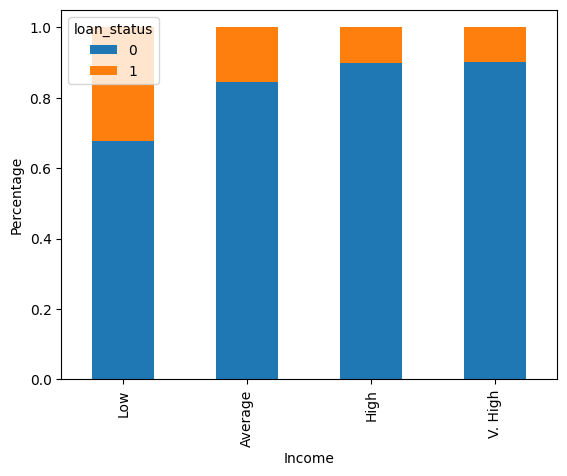

In [35]:
bins=[4000,50000,100000,150000,6000000]
group=['Low','Average','High', 'V. High']
main['person_income_bin'] = pd.cut(main['person_income'], bins, labels=group)
Applicant_Income_bin = pd.crosstab(main['person_income_bin'], main['loan_status'])
Applicant_Income_bin.div(Applicant_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel('Income')
plt.savefig("./images/bivar_income.png", dpi=1000, bbox_inches="tight")
P=plt.ylabel('Percentage')

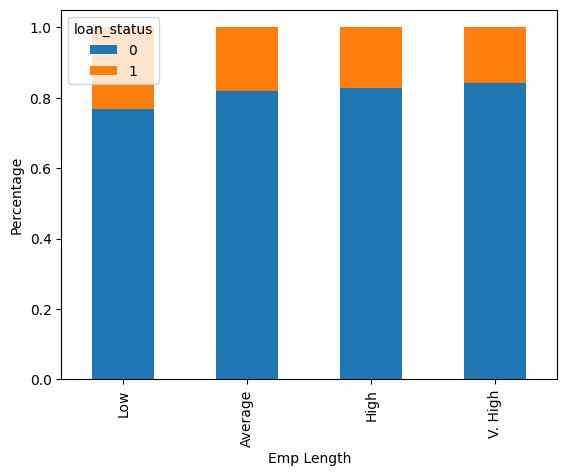

In [36]:
bins=[0,5,10,15,20]
group=['Low','Average','High', 'V. High']
main['person_emp_length_bin'] = pd.cut(main['person_emp_length'], bins, labels=group)
Emp_len_bin = pd.crosstab(main['person_emp_length_bin'], main['loan_status'])
Emp_len_bin.div(Emp_len_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel('Emp Length')
plt.savefig("./images/bivar_emp_length.png", dpi=1000, bbox_inches="tight")
P=plt.ylabel('Percentage')

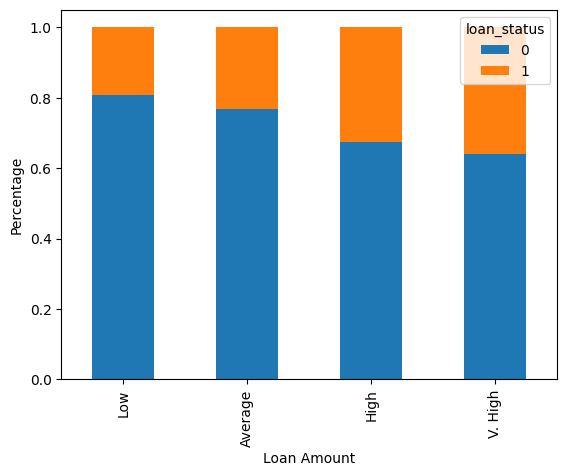

In [37]:
bins=[500,10000,15000,25000,35000]
group=['Low','Average','High', 'V. High']
main['loan_amount_bin'] = pd.cut(main['loan_amnt'], bins, labels=group)
Loan_amnt_bin = pd.crosstab(main['loan_amount_bin'], main['loan_status'])
Loan_amnt_bin.div(Loan_amnt_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel('Loan Amount')
plt.savefig("./images/bivar_amount.png", dpi=1000, bbox_inches="tight")
P=plt.ylabel('Percentage')

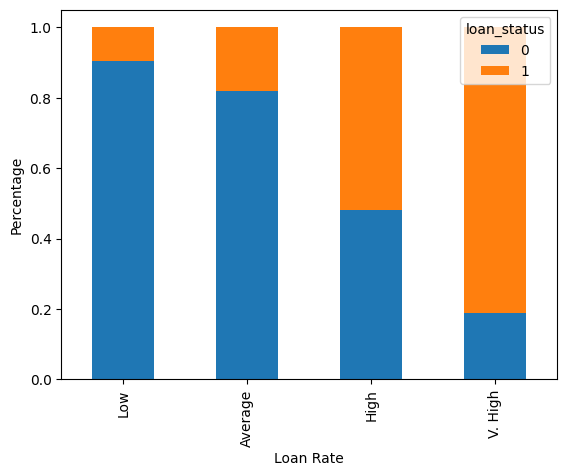

In [38]:
bins=[5,8,14,21,24]
group=['Low','Average','High', 'V. High']
main['loan_int_rate_bin'] = pd.cut(main['loan_int_rate'], bins, labels=group)
Loan_rate_bin = pd.crosstab(main['loan_int_rate_bin'], main['loan_status'])
Loan_rate_bin.div(Loan_rate_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel('Loan Rate')
plt.savefig("./images/bivar_rate.png", dpi=1000, bbox_inches="tight")
P=plt.ylabel('Percentage')

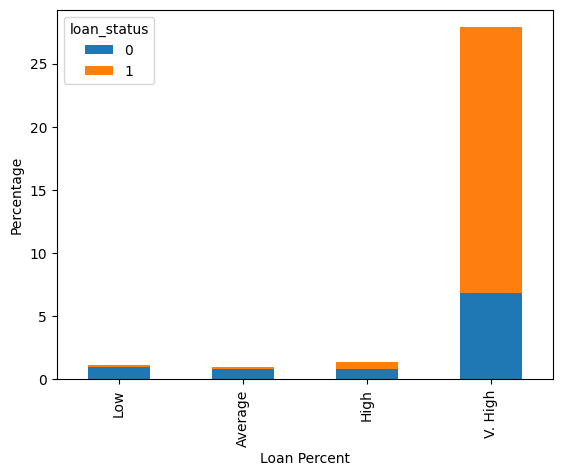

In [39]:
bins=[0,0.09,0.22,0.44,0.8]
group=['Low','Average','High', 'V. High']
main['loan_percent_bin'] = pd.cut(main['loan_percent_income'], bins, labels=group)
Loan_percent_bin = pd.crosstab(main['loan_percent_bin'], main['loan_status'])
Loan_percent_bin.div(Loan_rate_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel('Loan Percent')
plt.savefig("./images/bivar_percent.png", dpi=1000, bbox_inches="tight")
P=plt.ylabel('Percentage')

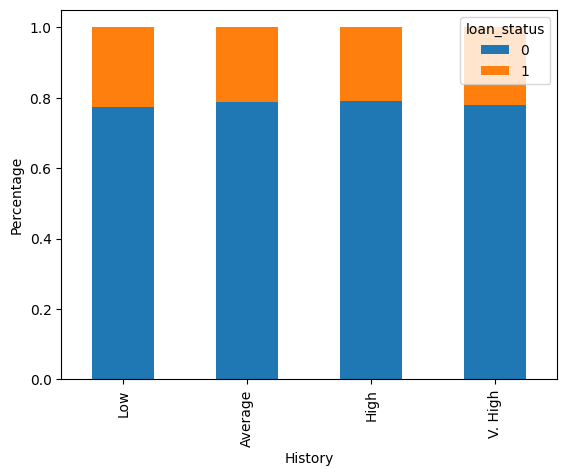

In [40]:
bins=[2,4,8,15,30]
group=['Low','Average','High', 'V. High']
main['history_bin'] = pd.cut(main['cb_person_cred_hist_length'], bins, labels=group)
Loan_hist_bin = pd.crosstab(main['history_bin'], main['loan_status'])
Loan_hist_bin.div(Loan_hist_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel('History')
plt.savefig("./images/bivar_hist.png", dpi=1000, bbox_inches="tight")
P=plt.ylabel('Percentage')

### Preprocessing

##### Filling Nulls

In [41]:
# Selection of the aforementioned features and relatable 
main = main[['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent',
       'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']].copy()


In [42]:
# Calculating mean for the features with null values and fill in missing values
len_mean = main['person_emp_length'].mean()
main['person_emp_length'].fillna(len_mean, inplace=True)
int_mean = main['loan_int_rate'].mean()
main['loan_int_rate'].fillna(int_mean, inplace=True)

##### Train Test Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    main.drop(['loan_status'], axis=1), main[['loan_status']], test_size=0.2, random_state=SEED, stratify=main['loan_status'])

##### Encoding Pipeline
Features to encode:

1. person_home_ownership
2. loan_intent 
3. loan_grade
4. cb_person_default_on_file

In [44]:
oenc = OrdinalEncoder()
oenc.fit(X_train[['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']])

OrdinalEncoder()

In [45]:
cat_trnsfmd_train = oenc.transform(X_train[['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']])
cat_trnsfmd_train = pd.DataFrame(cat_trnsfmd_train, columns=[
                                 'person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'], index=X_train.index)
cat_trnsfmd_test = oenc.transform(X_test[['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']])
cat_trnsfmd_test = pd.DataFrame(cat_trnsfmd_test, columns=[
                                 'person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'], index=X_test.index)


In [46]:
X_train = pd.concat([X_train.drop(['person_home_ownership', 'loan_intent',
                    'loan_grade', 'cb_person_default_on_file'], axis=1), cat_trnsfmd_train], axis=1)
X_test = pd.concat([X_test.drop(['person_home_ownership', 'loan_intent',
                    'loan_grade', 'cb_person_default_on_file'], axis=1), cat_trnsfmd_test], axis=1)

##### Scaling Pipeline

In [47]:
pipeline = Pipeline([('minmax', MinMaxScaler()), ('std', StandardScaler())])


In [48]:
x_train = pd.DataFrame(pipeline.fit_transform(X_train), columns=X_train.columns)
x_test = pd.DataFrame(pipeline.fit_transform(X_test), columns=X_test.columns)

#### Modelling

In [49]:
def experimenting(exp_info, model, tr_data, te_data, param_grid):
    logging.basicConfig(filename='./app.log', filemode='a', format='%(asctime)s - %(message)s', datefmt='%b-%d,%Y %H:%M:%S-%Z', level=logging.INFO)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)
    t1 = datetime.now()
    scores = cross_val_score(model, scoring='f1_micro',
                             cv=cv, n_jobs=-1, **tr_data)
    model.fit(**tr_data)
    tt = datetime.now() - t1
    pred = model.predict(te_data['X'])
    f1 = f1_score(te_data['y'], pred, average='micro')

    logging.info(
        f"Experiment: {exp_info['exp_name']} \nModel: {exp_info['model_name']} \nScore: {scores} \nMean Score: {np.mean(scores):.3f} \nStd: {np.std(scores):.3f} \nF1 Score: {f1:.3f} \nParam_grid: {param_grid} \nApprox. Training Time {tt.total_seconds() / 60:.3f} \n\n\n")

    path = f"./models/{exp_info['model_name']}"
    if not os.path.isdir(path):
        os.mkdir(path)
    if not os.path.exists(path+f"/{exp_info['model_name']}_{exp_info['version']}.joblib"):
        joblib.dump(
            model, path+f"/{exp_info['model_name']}_{exp_info['version']}.joblib")

In [50]:
tr_data = {'X': X_train,
           'y': y_train.values.ravel()}

te_data = {'X': X_test,
           'y': y_test.values.ravel()}

In [51]:
xgb_param = {'booster': 'dart',
            'eta': 0.05,
            'objective': 'binary:logistic',
            'eval_metric': 'error'}

imrf_param = {'criterion': 'entropy',
            'random_state' : 0,
            'sampling_strategy': 'not majority',
            'n_jobs': -1,
            'random_state': SEED}

In [52]:
imbrf = BalancedRandomForestClassifier(**imrf_param)
xgb = XGBClassifier(**xgb_param)

In [53]:
exp_info = {'exp_name': 'ICEA','model_name':'IMBalancedRF', 'version':'v1'}

In [54]:
experimenting(exp_info, imbrf, tr_data, te_data, imrf_param)

In [55]:
exp_info = {'exp_name': 'ICEA','model_name':'XGB', 'version':'v1'}

In [56]:
experimenting(exp_info, xgb, tr_data, te_data, xgb_param)

### Comparison of Models using the test Dataset

In [57]:
clf = joblib.load('./models/XGB/XGB_v1.joblib')

In [58]:
r = pd.read_csv('./credit_risk_dataset_test.csv')

In [59]:
r.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,NaN
1,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,NaN
2,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,0.44,N,4,NaN
3,26,108160,RENT,4.0,EDUCATION,E,35000,18.39,0.32,N,4,NaN
4,23,92111,RENT,7.0,MEDICAL,F,35000,20.25,0.32,N,4,NaN


In [60]:
# Calculating mean for the features with null values and fill in missing values
len_mean = r['person_emp_length'].mean()
r['person_emp_length'].fillna(len_mean, inplace=True)
int_mean = r['loan_int_rate'].mean()
r['loan_int_rate'].fillna(int_mean, inplace=True)

In [61]:
res = r.copy().drop('loan_status', axis=1)

In [62]:
trnsfmd_r = oenc.transform(res[['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']])
trnsfmd_r = pd.DataFrame(trnsfmd_r, columns=[
                         'person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'], index=res.index)

In [63]:
res = pd.concat([res.drop(['person_home_ownership', 'loan_intent',
                       'loan_grade', 'cb_person_default_on_file'], axis=1), trnsfmd_r], axis=1)

In [64]:
res = pd.DataFrame(pipeline.fit_transform(res), columns=res.columns)


In [65]:
res.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,-0.433765,-1.003582,-0.907025,-0.645890,0.607958,3.726594,-0.691480,-1.169882,0.257679,0.669995,-0.459923
1,-0.590132,-0.208499,0.779176,4.029903,1.064453,3.540213,-0.445473,0.920738,0.257679,0.669995,2.174278
2,-0.590132,0.227306,0.056519,4.029903,0.034079,2.515115,-0.445473,0.920738,0.257679,-0.184714,-0.459923
3,-0.277398,0.745601,-0.184367,4.029903,2.407851,1.396826,-0.445473,0.920738,-0.897307,2.379413,-0.459923
4,-0.746499,0.460773,0.538290,4.029903,3.014336,1.396826,-0.445473,0.920738,0.257679,3.234122,-0.459923


In [66]:
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  9731 non-null   float64
 1   person_income               9731 non-null   float64
 2   person_emp_length           9731 non-null   float64
 3   loan_amnt                   9731 non-null   float64
 4   loan_int_rate               9731 non-null   float64
 5   loan_percent_income         9731 non-null   float64
 6   cb_person_cred_hist_length  9731 non-null   float64
 7   person_home_ownership       9731 non-null   float64
 8   loan_intent                 9731 non-null   float64
 9   loan_grade                  9731 non-null   float64
 10  cb_person_default_on_file   9731 non-null   float64
dtypes: float64(11)
memory usage: 836.4 KB


In [67]:
pred = clf.predict(res)

In [68]:
r['loan_status']=pred

In [69]:
r['loan_status'].value_counts(normalize=True)

0    0.626554
1    0.373446
Name: loan_status, dtype: float64

In [70]:
r.to_csv("./results.csv", index=False)